In [28]:
# Reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import numpy as np
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from defense import train_test_split, train_defense_classifier, test_model, threshold_baseline, get_best_threshold, get_best_confidence_threshold, confidence_threshold
from util_plotting import plot_mse_predictions, plot_mse_vs_confidence, better_plot_wdr, plot_confidence_histogram

In [30]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    try:
        df["logit_diffs"] = [np.array(eval(','.join(row["logit_diffs"].split()))) for _, row in df.iterrows()]
    except:
        df["logit_diffs"] = [np.array(eval(row["logit_diffs"].replace(";", ","))) for _, row in df.iterrows()]
    
    return df

base = load_csv("base_logit_diffs.csv")
adversarial = load_csv("adversarial_logit_diffs.csv")
far_boundary = load_csv("far_boundary_logit_diffs.csv")
very_far_boundary = load_csv("very_far_boundary_logit_diffs.csv")
very_very_far_boundary = load_csv("very_very_far_boundary_logit_diffs.csv")

In [31]:
low_confidence_base = base[base["confidence"] < 0.8]
very_high_confidence_base = base[base["confidence"] > 0.97]
very_very_high_confidence_base = base[base["confidence"] > 0.997]

In [32]:
# filter out the ones with confidence < 0.5
base = base[base["confidence"] > 0.5]
adversarial = adversarial[adversarial["confidence"] > 0.5]
far_boundary = far_boundary[far_boundary["confidence"] > 0.8]
very_far_boundary = very_far_boundary[very_far_boundary["confidence"] > 0.97]
very_very_far_boundary = very_very_far_boundary[very_very_far_boundary["confidence"] > 0.997]

low_confidence_base = low_confidence_base[low_confidence_base["confidence"] > 0.5]

In [33]:
base.head()

,logit_diffs,is_adversarial,is_adversarial_success,text,confidence
0,"[5.77769756, 6.04660416, 6.58319664, 6.6471090...",False,False,I love sci-fi and am willing to put up with a ...,0.998834
1,"[3.95301652, 4.05837154, 4.30562973, 4.3743863...",False,False,"[[Worth]] the entertainment value of a rental,...",0.992764
2,"[3.67921662, 4.28683853, 4.50494146, 4.5423278...",False,False,its a totally average film with a few semi-alr...,0.993402
3,"[6.67397118, 6.75999546, 6.78043842, 6.7812657...",False,False,STAR RATING: ***** Saturday Night **** Friday ...,0.998911
5,"[4.12109089, 4.37859058, 4.40275621, 4.4232211...",False,False,I had high hopes for this one until they chang...,0.993648


In [34]:
adversarial.head()

,logit_diffs,is_adversarial,is_adversarial_success,text,confidence
0,"[-5.32612133, -4.30745554, -2.76181173, -2.256...",True,True,I love sci-fi and am willing to put up with a ...,0.536722
1,"[-2.6117754, -1.91892338, -1.82763648, -1.3369...",True,True,[[Valued]] the entertainment value of a rental...,0.576850
2,"[-4.39465046, -3.51081586, -2.60699081, -1.875...",True,True,its a totally average film with a few semi-alr...,0.684158
3,"[-3.36404133, -2.72102547, -2.60226464, -2.042...",True,True,STAR RATING: ***** Saturday Night **** Friday ...,0.639855
4,"[5.00643778, 5.10394478, 5.18392658, 5.2229385...",True,False,"First off let me say, If you haven't enjoyed a...",0.996991


In [35]:
train_x, train_y, test_x, test_y = train_test_split(base, adversarial, 0.8, column="confidence", seed = 0)

print(len(train_x), len(test_x), len(train_y), len(test_y))

Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
912 458 912 458


In [36]:
multiseed_accs_confidence = []
for seed in range(100):
    train_x, train_y, test_x, test_y = train_test_split(base, adversarial, 0.8, column="confidence", seed = seed)

    # Get best confidence threshold
    best_threshold = get_best_confidence_threshold(train_x, train_y)
    # print("Best threshold: ", best_threshold)

    # Get best confidence threshold accuracy
    # train_accuracy = confidence_threshold(train_x, train_y, best_threshold)
    # print("Train accuracy: ", train_accuracy)

    test_accuracy = confidence_threshold(test_x, test_y, best_threshold)
    # print("Test accuracy: ", test_accuracy)

    multiseed_accs_confidence.append(test_accuracy)
    
print("Average test accuracy: ", np.mean(multiseed_accs_confidence))
print("Standard deviation of test accuracy: ", np.std(multiseed_accs_confidence))


Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
low: 0.5001790523529053, high: 0.9992056488990784
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
low: 0.5002678632736206, high: 0.9991925358772278
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
low: 0.5000870227813721, high: 0.9992114305496216
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
low: 0.5009700655937195, high: 0.9992114305496216
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
low: 0.5001790523529053, high:

In [56]:
best_threshold

0.9152953466611142

Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
912 458 912 458
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
912 458 912 458
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
912 458 912 458
Number of base train example

Text(0, 0.5, 'Threshold')

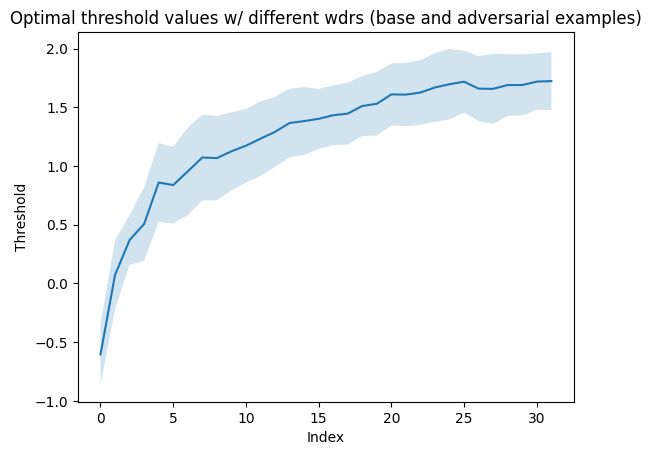

In [37]:
multiseed_accs = []
multiseed_thresholds = []
for seed in range(100):
    train_x, train_y, test_x, test_y = train_test_split(base, adversarial, 0.8, column="logit_diffs", seed = seed)
    train_x_conf, _, test_x_conf, _ = train_test_split(base, adversarial, 0.8, column="confidence", seed = seed)
    def plot_best_thresholded_accuracy(train_x, train_y, test_x, test_y, title = "", index_max = 32):
        # y axis is accuracy, x axis index 
        accuracies = []
        thresholds = []
        for i in range(index_max):
            threshold = get_best_threshold(train_x, train_y, i)
            thresholds.append(threshold)
            accuracies.append(threshold_baseline(test_x, test_y, threshold, i))
            
        # plt.title(title)

        # plt.plot(range(index_max), accuracies)
        # plt.xlabel("Index")
        # plt.ylabel("Accuracy")
        
        # plt.show()

        # plt.title("Optimal threshold values w/ different wdrs (base and adversarial examples)")
        # plt.plot(range(index_max), thresholds)
        # plt.xlabel("Index")
        # plt.ylabel("Threshold")
        
        # plt.show()
        

        return thresholds, accuracies

        

    print(len(train_x), len(test_x), len(train_y), len(test_y))

    a,b =plot_best_thresholded_accuracy(train_x, train_y, test_x, test_y, "Optimal thresholded accuracy w/ different wdrs (base and adversarial examples)")
    multiseed_accs.append(b)
    multiseed_thresholds.append(a)
    
# Plot mean and std of accuracies
multiseed_accs = np.array(multiseed_accs)
multiseed_thresholds = np.array(multiseed_thresholds)

mean_accs = np.mean(multiseed_accs, axis = 0)
std_accs = np.std(multiseed_accs, axis = 0)

mean_thresholds = np.mean(multiseed_thresholds, axis = 0)
std_thresholds = np.std(multiseed_thresholds, axis = 0)

plt.title("Optimal threshold values w/ different wdrs (base and adversarial examples)")

plt.plot(range(32), mean_thresholds)

plt.fill_between(range(32), mean_thresholds - std_thresholds, mean_thresholds + std_thresholds, alpha = 0.2)

plt.xlabel("Index")

plt.ylabel("Threshold")

Text(0, 0.5, 'Threshold')

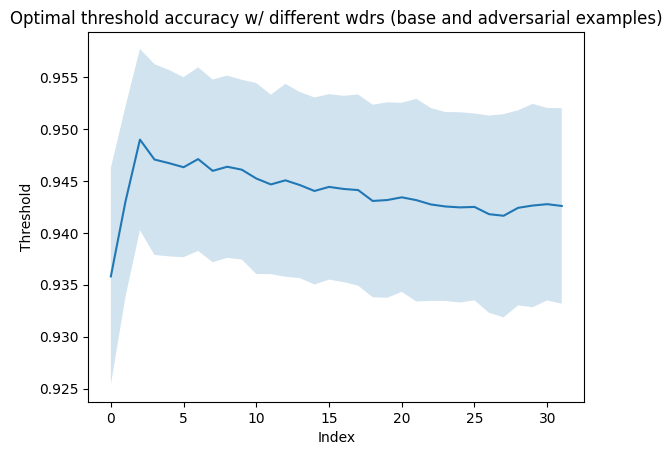

In [38]:
plt.title("Optimal threshold accuracy w/ different wdrs (base and adversarial examples)")

plt.plot(range(32), mean_accs)

plt.fill_between(range(32), mean_accs - std_accs, mean_accs + std_accs, alpha = 0.2)

plt.xlabel("Index")

plt.ylabel("Threshold")

In [39]:
# For index 1
index_1_accs = multiseed_accs[:, 1]
print("Mean acc for index 1: ", np.mean(index_1_accs))
print("Std acc for index 1: ", np.std(index_1_accs))

Mean acc for index 1:  0.9429912663755458
Std acc for index 1:  0.009180151711518817


In [40]:
import scipy.stats as stats

# Function 1
mean1 = 0.9475
std1 = 0.00879
n1 = 100

# Function 2
mean2 = 0.9472270742358078
std2 = 0.008613004394615424
n2 = 100

# Calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2)

# Since we are only interested in the likelihood that function 1 is better than function 2,
# we only consider the one-tailed p-value
one_tailed_p_value = p_value / 2

print(f"t-statistic: {t_statistic}")
print(f"one-tailed p-value: {one_tailed_p_value}")

if one_tailed_p_value < 0.05:
    print("Reject the null hypothesis. There is significant evidence that function 1 is better than function 2.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude that function 1 is better than function 2.")


t-statistic: 0.22177513028612672
one-tailed p-value: 0.4123587537085429
Fail to reject the null hypothesis. There is not enough evidence to conclude that function 1 is better than function 2.


In [41]:
multiseed_accs = []
for seed in range(100):
    train_x, train_y, test_x, test_y = train_test_split(base, adversarial, 0.8, column="logit_diffs", seed = seed)
    model = train_defense_classifier(train_x, train_y)
    predictions, accuracy = test_model(model, test_x, test_y, verbose = False)
    multiseed_accs.append(accuracy)


# Print mean and std of accuracies
multiseed_accs = np.array(multiseed_accs)
mean_accs = np.mean(multiseed_accs, axis = 0)
std_accs = np.std(multiseed_accs, axis = 0)

print("Mean accuracy: ", mean_accs)
print("Std accuracy: ", std_accs)

Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Number of base train examples: 456, number of adversarial train examples: 45

In [42]:
model = train_defense_classifier(train_x, train_y)

multiseed_accs = []
for seed in range(100):
    train_x, train_y, test_x, test_y = train_test_split(base, adversarial, 0.8, column="logit_diffs", seed = seed)
    predictions, accuracy = test_model(model, test_x, test_y)
    multiseed_accs.append(accuracy)


# Print mean and std of accuracies
multiseed_accs = np.array(multiseed_accs)
mean_accs = np.mean(multiseed_accs, axis = 0)
std_accs = np.std(multiseed_accs, axis = 0)

print("Mean accuracy: ", mean_accs)
print("Std accuracy: ", std_accs)

# print(type(test_x_conf), type(test_y))


Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9650655021834061
Adversarial accuracy: 0.9563318777292577
Overall accuracy: 0.9606986899563319
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9301310043668122
Adversarial accuracy: 0.9563318777292577
Overall accuracy: 0.9432314410480349
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9388646288209607
Adversarial accuracy: 0.9737991266375546
Overall accuracy: 0.9563318777292577
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.925764192139738
Adversarial acc

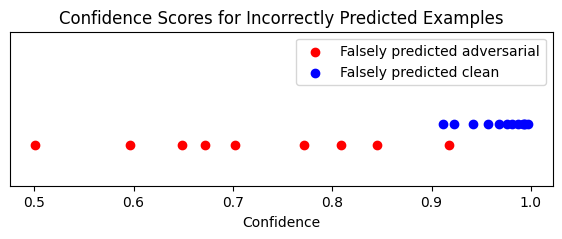

Falsely predicted adversarial:  9
Falsely predicted base:  12
458


In [55]:
def plot_errors_vs_confidence(model, test_x, test_y, title = ""):
    # For each one in test_
    # Plot errors vs confidence, red means predicted adversarial, blue means predicted base
    # This is 1 dimensional
    plt.figure(figsize = (7, 2))
    
    falsely_predicted_adversarial = []
    falsely_predicted_base = []    
    predictions = model.predict(test_x)
    for i in range(len(predictions)):
        if predictions[i] == 0:
            if test_y[i] == 1:
                plt.scatter(test_x_conf.iloc[i], 0.1, color = "blue", label = "Falsely predicted clean")
                falsely_predicted_base.append(test_x_conf.iloc[i])
        else:
            if test_y[i] == 0:
                plt.scatter(test_x_conf.iloc[i], -0.1, color = "red", label = "Falsely predicted adversarial")
                falsely_predicted_adversarial.append(test_x_conf.iloc[i])
    plt.title(title)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Hide y axis
    plt.yticks([])

    # Set y limit as -1 to 1
    plt.ylim(-0.5, 1)

    # X axis is confidence
    plt.xlabel("Confidence")
    
    plt.show()
    print("Falsely predicted adversarial: ", len(falsely_predicted_adversarial))
    print("Falsely predicted base: ", len(falsely_predicted_base))    
plot_errors_vs_confidence(model, test_x, test_y, "Confidence Scores for Incorrectly Predicted Examples")
print(len(test_x))

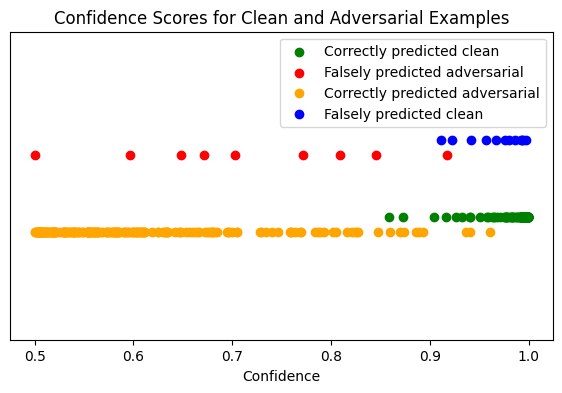

Falsely predicted adversarial:  9
Falsely predicted base:  12
458


In [54]:
def plot_errors_vs_confidence(model, test_x, test_y, title = ""):
    # For each one in test_
    # Plot errors vs confidence, red means predicted adversarial, blue means predicted base
    # This is 1 dimensional
    plt.figure(figsize = (7, 4))
    
    falsely_predicted_adversarial = []
    falsely_predicted_base = []    
    predictions = model.predict(test_x)
    for i in range(len(predictions)):
        if predictions[i] == 0:
            if test_y[i] == 1:
                plt.scatter(test_x_conf.iloc[i], 0.3, color = "blue", label = "Falsely predicted clean")
                falsely_predicted_base.append(test_x_conf.iloc[i])
            else:
                plt.scatter(test_x_conf.iloc[i], -0.2, color = "green", label = "Correctly predicted clean")
        else:
            if test_y[i] == 0:
                plt.scatter(test_x_conf.iloc[i], 0.2, color = "red", label = "Falsely predicted adversarial")
                falsely_predicted_adversarial.append(test_x_conf.iloc[i])
            else:
                plt.scatter(test_x_conf.iloc[i], -0.3, color = "orange", label = "Correctly predicted adversarial")
    plt.title(title)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Hide y axis
    plt.yticks([])

    # Set y limit as -1 to 1
    plt.ylim(-1, 1)

    # X axis is confidence
    plt.xlabel("Confidence")
    
    plt.show()
    print("Falsely predicted adversarial: ", len(falsely_predicted_adversarial))
    print("Falsely predicted base: ", len(falsely_predicted_base))    
plot_errors_vs_confidence(model, test_x, test_y, "Confidence Scores for Clean and Adversarial Examples")
print(len(test_x))

In [19]:
far_boundary_testing = far_boundary["logit_diffs"]
far_boundary_testing = [list(x) for x in far_boundary_testing]
print(len(far_boundary_testing))

test_model(model, far_boundary_testing, [1] * len(far_boundary_testing))

1044
Adversarial accuracy: 0.8591954022988506
Overall accuracy: 0.8591954022988506


(array([1, 1, 1, ..., 1, 1, 1]), 0.8591954022988506)

In [20]:
# Combine Dataframes
better_set = pd.concat([very_far_boundary[:200], very_very_far_boundary])

train_x, train_y, test_x, test_y = train_test_split(base, very_very_far_boundary, 0.8, column="logit_diffs", seed = seed)
model = train_defense_classifier(train_x, train_y)
test_model(model, test_x, test_y)

Number of base train examples: 372, number of adversarial train examples: 373
Number of base test examples: 187, number of test adversarial examples: 187
Base accuracy: 0.4117647058823529
Adversarial accuracy: 0.893048128342246
Overall accuracy: 0.6524064171122995


(array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
from sklearn import preprocessing
# Normalize the logit diffs
def normalize_logit_diffs(logit_diffs):
    normalized_logit_diffs = preprocessing.normalize([logit_diffs])
    
    return normalized_logit_diffs[0]

# create a copy of the dataframe
normalized_base = base.copy(deep=True)
normalized_adversarial = adversarial.copy(deep=True)

# for each logit diff, normalize it
normalized_base["logit_diffs"] = normalized_base["logit_diffs"].apply(normalize_logit_diffs)
normalized_adversarial["logit_diffs"] = normalized_adversarial["logit_diffs"].apply(normalize_logit_diffs)


normalized_very_far_boundary = very_far_boundary.copy(deep=True)
normalized_very_very_far_boundary = very_very_far_boundary.copy(deep=True)

normalized_very_far_boundary["logit_diffs"] = normalized_very_far_boundary["logit_diffs"].apply(normalize_logit_diffs)
normalized_very_very_far_boundary["logit_diffs"] = normalized_very_very_far_boundary["logit_diffs"].apply(normalize_logit_diffs)

In [22]:
normalized_accs = []
for seed in range(300):
    # Split into train and test
    normalized_train_x, normalized_train_y, normalized_test_x, normalized_test_y = train_test_split(normalized_base, normalized_adversarial, 0.8, column="logit_diffs", seed = seed)
    model = train_defense_classifier(normalized_train_x, normalized_train_y)
    normalized_accs.append(test_model(model, normalized_test_x, normalized_test_y)[1])
    
# Print mean and std of accuracies
normalized_accs = np.array(normalized_accs)
mean_accs = np.mean(normalized_accs, axis = 0)
std_accs = np.std(normalized_accs, axis = 0)

print("Mean accuracy: ", mean_accs)
print("Std accuracy: ", std_accs)

Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9912663755458515
Adversarial accuracy: 0.9170305676855895
Overall accuracy: 0.9541484716157205
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9519650655021834
Adversarial accuracy: 0.9432314410480349
Overall accuracy: 0.9475982532751092
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9737991266375546
Adversarial accuracy: 0.9519650655021834
Overall accuracy: 0.962882096069869
Number of base train examples: 456, number of adversarial train examples: 456
Number of base test examples: 229, number of test adversarial examples: 229
Base accuracy: 0.9563318777292577
Adversarial acc

In [23]:
normalized_train_x, normalized_train_y, normalized_test_x, normalized_test_y = train_test_split(normalized_base, normalized_very_very_far_boundary, 0.8, column="logit_diffs", seed = seed)

model = train_defense_classifier(normalized_train_x, normalized_train_y)

# normalize_far_test = [list(x) for x in normalized_very_far_boundary["logit_diffs"]]
test_model(model, normalized_test_x, normalized_test_y)

# plot_errors_vs_confidence(model, normalized_test_x, normalized_test_y, "Errors vs confidence (base and adversarial examples)")

Number of base train examples: 372, number of adversarial train examples: 373
Number of base test examples: 187, number of test adversarial examples: 187
Base accuracy: 0.2994652406417112
Adversarial accuracy: 0.8556149732620321
Overall accuracy: 0.5775401069518716


(array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 

In [24]:
def print_text(text):
    for i in range(0, len(text), 100):
        print(text[i:i+100])
for i in range(5):
    print(far_boundary["text"][i])
    print("\n\n")

I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star [[Trekking]] (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just [[gone]] a spark of life. Their actions and reactions are [[bois]] and [[predicted]], [[generally]] [[painstaking]] to watch. The makers of Earth KNOW it's 